In [1]:
import torch
import torchvision 
import torchvision.transforms as transforms 
import torchvision.models as models 
import torch.optim as optim 
import torch.nn as nn 
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.colors

from collections import OrderedDict

In [3]:
def softmax(x, T=1):
    return np.exp(x/T)/sum(np.exp(x/T))

In [4]:
# Load and normalise data 
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

train_batch_size, test_batch_size = 128, 1024
trainset = torchvision.datasets.CIFAR100(root = './data', train = True, download = True, transform = transformation)
testset = torchvision.datasets.CIFAR100(root = './data', train = False, download = True, transform = transformation)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = test_batch_size, shuffle = False)

num_classes = 100

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Load generalist model (resnet-20)
generalist_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained = False)
generalist_state_dict = torch.load("../input/specialists/teacher_model_cifar100.pth")
generalist_model.load_state_dict(generalist_state_dict)
if torch.cuda.is_available(): 
    generalist_model = generalist_model.cuda() 
    
sub_class = [12, 17, 23, 33, 37, 47, 49, 52, 56, 59, 60, 68, 69, 71, 76, 81, 85, 90, 96]
specialist_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained = False)
specialist_model.fc = nn.Linear(specialist_model.fc.in_features, len(sub_class) + 1)
specialist_state_dict = torch.load("../input/sdataset/specialist_0_debug.pth")
specialist_model.load_state_dict(specialist_state_dict)
if torch.cuda.is_available(): 
    specialist_model = specialist_model.cuda() 

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/archive/master.zip" to /root/.cache/torch/hub/master.zip
Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [8]:
def count_corrects_and_wrongs(generalist_model, specialist_model, testloader, sub_class): 
    """ 
    This function calculates the number of examples where: 
    (i) Only the generalist model is used and the generalist prediction is correct. 
    (ii) Only the generalist model is used and the generalist prediction is wrong. 
    (iii) Both the generalist and speciaist models are used. Both models give the correct prediction. 
    (iv) Both the generalist and specialist models are used. The generalist is correct, but the specialist is wrong. 
    (v) Both the generalist and specialist models are used. The generalist is wrong, but the specialist is correct.
    (vi)  Both the generalist and specialist models are used. Both models give the wrong prediction. 
    
    Note: We consider only one specialist model here. We are not running the iterative algorithm here, but simply 
    calculating (i) - (vi) based on the generalist and specialist's predictions. 
    """
    
    specialist_called_total, g_correct_s_correct, g_correct_s_wrong, g_wrong_s_correct, g_wrong_s_wrong = 0, 0, 0, 0, 0
    correct, wrong = 0, 0
    dustbin_class = len(sub_class)
    for i, data in enumerate(testloader, 0): 
        inputs, labels = data 
        if torch.cuda.is_available(): 
            inputs, labels = inputs.cuda(), labels.cuda() 
            
        outputs = generalist_model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        specialist_outputs = specialist_model(inputs)
        _, specialist_preds = torch.max(specialist_outputs.data, 1)
        
        num_examples_per_batch = labels.shape[0]
        for index in range(num_examples_per_batch): 
            pred, label = preds[index], labels[index]
            
            # If baseline predicted class belongs to subset of specialist
            if pred in sub_class:
                specialist_called_total += 1 
                
                # If specialist prediction is not dustbin class
                if specialist_preds[index] != dustbin_class: 
                    specialist_pred = sub_class[specialist_preds[index]]
                    if pred == label and specialist_pred == label: 
                        g_correct_s_correct += 1
                    elif pred == label and specialist_pred != label: 
                        g_correct_s_wrong += 1 
                    elif pred != label and specialist_pred == label: 
                        g_wrong_s_correct += 1 
                    elif pred != label and specialist_pred != label: 
                        g_wrong_s_wrong += 1
                
                # If specialist prediction is dustbin class, the q distribution follows the generalist model 
                else: 
                    if pred == label: 
                        correct += 1 
                    else: 
                        wrong += 1
                        
            # If baseline predicted class does not belong to subset of specialist and we only run generalist model: 
            else: 
                if pred == label: 
                    correct += 1 
                else: 
                    wrong += 1 
    
    return specialist_called_total, g_correct_s_correct, g_correct_s_wrong, g_wrong_s_correct, g_wrong_s_wrong, correct, wrong

In [9]:
testloader = torch.utils.data.DataLoader(testset, batch_size = 16, shuffle = False)
total, g_correct_s_correct, g_correct_s_wrong, g_wrong_s_correct, g_wrong_s_wrong, correct, wrong = count_corrects_and_wrongs(generalist_model, specialist_model, testloader, sub_class)
print("Total number of examples where the specialist model is called: {}".format(total))
print("Generalist correct, specialist correct: {} examples".format(g_correct_s_correct))
print("Generalist correct, specialist wrong: {} examples".format(g_correct_s_wrong))
print("Generalist incorrect, specialist correct: {} examples".format(g_wrong_s_correct))
print("Generalist incorrect, specialist incorrect: {} examples".format(g_wrong_s_wrong))
print("Generalist correct: {} examples".format(correct))
print("Generalist incorrect: {} examples".format(wrong))

Total number of examples where the specialist model is called: 1909
Generalist correct, specialist correct: 1179 examples
Generalist correct, specialist wrong: 162 examples
Generalist incorrect, specialist correct: 97 examples
Generalist incorrect, specialist incorrect: 471 examples
Generalist correct: 4897 examples
Generalist incorrect: 3194 examples


In [11]:
def get_predicted_class(baseline_class, generalist_output, specialist_output, sub_classes): 
     
    num_classes = 100 
    q_dist = torch.randn(num_classes, requires_grad = True, device = "cuda:0")
    
    optimizer = optim.Adam([q_dist], lr = 0.01)
    criterion = nn.KLDivLoss() 
    previous_loss = 10000.0
    loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
    if baseline_class in sub_classes: 
        modified_q_dist = np.zeros(len(sub_classes) + 1)
        q_dist_copy = q_dist.clone() 
        for index in range(len(sub_classes)): 
            modified_q_dist[index] = q_dist_copy[sub_classes[index]]
            q_dist_copy[sub_classes[index]] = 0.0
        
        modified_q_dist[len(sub_classes)] = torch.sum(q_dist_copy)
        modified_q_dist = torch.tensor(modified_q_dist)
        if torch.cuda.is_available(): 
            modified_q_dist = modified_q_dist.cuda() 
        
        loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_output))
        
    niter = 0
    history = OrderedDict()
    
    #while loss > 1e-3: 
    while previous_loss > loss and loss > 1e-4: 
        previous_loss = loss 
        loss.backward(retain_graph = True)
        optimizer.step()
        optimizer.zero_grad()
        loss = criterion(F.log_softmax(q_dist), F.softmax(generalist_output))
        
        if baseline_class in sub_classes: 
            modified_q_dist = np.zeros(len(sub_classes) + 1)
            q_dist_copy = q_dist.clone() 
            for index in range(len(sub_classes)): 
                modified_q_dist[index] = q_dist_copy[sub_classes[index]]
                q_dist_copy[sub_classes[index]] = 0.0
        
            modified_q_dist[len(sub_classes)] = torch.sum(q_dist_copy)
            modified_q_dist = torch.tensor(modified_q_dist)
            if torch.cuda.is_available(): 
                modified_q_dist = modified_q_dist.cuda() 
        
        loss += criterion(F.log_softmax(modified_q_dist), F.softmax(specialist_output))
        
        niter+=1
        if niter % 50 == 0:
            #print("i: {:>4}, loss: {:.7f}".format(niter, loss))
            history[niter]=dict(logit=q_dist.detach().clone(), loss=loss.detach().clone())
            
    _, predicted = torch.max(q_dist.data, 0)
    return predicted, q_dist, history



def inspect_ensemble_predictions(generalist_model, specialist_model, testloader, sub_class): 
    """
    This function runs the iterative algorithm on examples where: 
    (i) The generalist model is correct, but the specialist model is wrong;
    (ii) The generalist model is wrong, but the specialist model is correct. 
    
    We do not have to consider other cases. The 'debug_iterative_logit_optimisation' notebook has given us 
    assurance that the iterative algorithm will converge to the right set of probability distribution if 
    the reference distribution from the generalist or specialist is correct. 
    """
    
    indices = [] 
    g_correct_s_wrong_e_correct, g_correct_s_wrong_e_wrong, g_wrong_s_correct_e_correct, g_wrong_s_correct_e_wrong = 0, 0, 0, 0
    dustbin_class = len(sub_class)
    for i, data in enumerate(testloader, 0): 
        inputs, labels = data 
        if torch.cuda.is_available(): 
            inputs, labels = inputs.cuda(), labels.cuda() 
            
        outputs = generalist_model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        specialist_outputs = specialist_model(inputs)
        _, specialist_preds = torch.max(specialist_outputs.data, 1)
        
        num_examples_per_batch = labels.shape[0]
        for index in range(num_examples_per_batch): 
            pred, label = preds[index], labels[index]
            
            if pred in sub_class:  
                if specialist_preds[index] != dustbin_class:
                    specialist_pred = sub_class[specialist_preds[index]]
                    if pred == label and specialist_pred != label: 
                        ensemble_pred, q_dist, history = get_predicted_class(pred, outputs[index], specialist_outputs[index], sub_class)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, 0])
                            g_correct_s_wrong_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, 1])
                            g_correct_s_wrong_e_wrong += 1
                        
                    elif pred != label and specialist_pred == label: 
                        ensemble_pred, q_dist, history = get_predicted_class(pred, outputs[index], specialist_outputs[index], sub_class)
                        if ensemble_pred == label: 
                            indices.append([i, index, label, pred, specialist_pred, 2])
                            g_wrong_s_correct_e_correct += 1     
                        else: 
                            indices.append([i, index, label, pred, specialist_pred, 3])
                            g_wrong_s_correct_e_wrong += 1
                            
    return indices, g_correct_s_wrong_e_correct, g_correct_s_wrong_e_wrong, g_wrong_s_correct_e_correct, g_wrong_s_correct_e_wrong 

In [12]:
indices, g_correct_s_wrong_e_correct, g_correct_s_wrong_e_wrong, g_wrong_s_correct_e_correct, g_wrong_s_correct_e_wrong = inspect_ensemble_predictions(generalist_model, specialist_model, testloader, sub_class)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2887: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Imp

In [13]:
print(" Out of {} examples where the generalist is correct but specialist is incorrect, the ensemble predicted {} correctly and {} incorrectly.".format(
    g_correct_s_wrong_e_correct + g_correct_s_wrong_e_wrong, g_correct_s_wrong_e_correct, g_correct_s_wrong_e_wrong))
print("Out of {} examples where the generalist is wrong but specialist is correct, the ensemble predicted {} correctly and {} incorrectly. ".format(
g_wrong_s_correct_e_correct + g_wrong_s_correct_e_wrong, g_wrong_s_correct_e_correct, g_wrong_s_correct_e_wrong))

 Out of 162 examples where the generalist is correct but specialist is incorrect, the ensemble predicted 120 correctly and 42 incorrectly.
Out of 97 examples where the generalist is wrong but specialist is correct, the ensemble predicted 17 correctly and 80 incorrectly. 


In [15]:
def evaluate(model, testloader): 
    test_correct, test_total = 0, 0 
  
    with torch.no_grad(): 
        for data in testloader: 
            images, labels = data 
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda() 
      
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).cpu().sum().item() 
      
    return test_correct*100/test_total

print("The testing accuracy of the generalist model (Baseline accuracy) is {} %".format(evaluate(generalist_model, testloader)))
print("The testing accuracy of the generalist + specialist model is {} %".format((g_correct_s_correct + correct + g_correct_s_wrong_e_correct + g_wrong_s_correct_e_correct)/100))

The testing accuracy of the generalist model (Baseline accuracy) is 62.38 %
The testing accuracy of the generalist + specialist model is 62.13 %


In [20]:
def retrieve_iteration_history(batch_index, index, testloader, generalist_model, specialist_model, sub_class): 
    """ 
    Get the iteration history for an example. 
    If index_label ==0, we retrieve the history for when the generalist is correct, specialist is wrong, and ensemble prediction is correct.
    If index_label ==1, we retrieve the history for when the generalist is correct, specialist is wrong, and ensemble prediction is wrong. 
    If index_label ==2, we retrieve the history for when the generalist is wrong, specialist is correct, and ensemble prediction is correct. 
    If index_label ==3, we retrieve the history for when the generalist is wrong, specialist is correct, and ensemble prediction is wrong. 
    """
    
    for i, data in enumerate(testloader, 0): 
        if i != batch_index: 
            continue
        
        inputs, labels = data 
        if torch.cuda.is_available(): 
            inputs, labels = inputs.cuda(), labels.cuda() 
        
        outputs = generalist_model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        specialist_outputs = specialist_model(inputs)
        _, specialist_preds = torch.max(specialist_outputs.data, 1)
        
        predicted, q_dist, history = get_predicted_class(preds[index], outputs[index], specialist_outputs[index], sub_class)
        
        return outputs[index], specialist_outputs[index], labels[index], predicted, q_dist, history

In [34]:
# Example 1: Generalist wrong, specialist correct, ensemble prediction wrong
output, specialist_output, label, ensemble_predicted, q_dist, history = retrieve_iteration_history(2, 7, testloader, generalist_model, specialist_model, sub_class)
print("True label: {}".format(label))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been dep

True label: 37


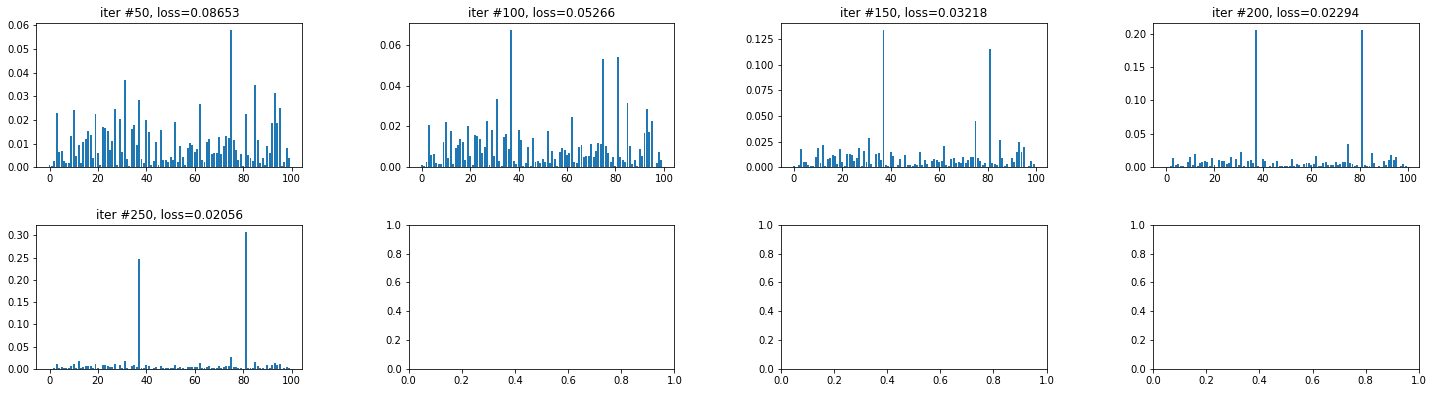

In [35]:
ncol=4
nrow=len(history)//ncol

if len(history) % ncol > 0:
    nrow += 1

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*6, nrow*3))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

for i, (niter, history_dict) in enumerate(history.items()):
    loss=history_dict['loss']
    q_logit=history_dict['logit']
    
    r=i//ncol
    c=i%ncol
    
    axes[r, c].bar(np.arange(q_logit.shape[0]), softmax(q_logit.detach().cpu().numpy()))
    axes[r, c].set_title("iter #{}, loss={:0.5f}".format(niter, loss))

Text(0.5, 1.0, 'Specialist probability distribution')

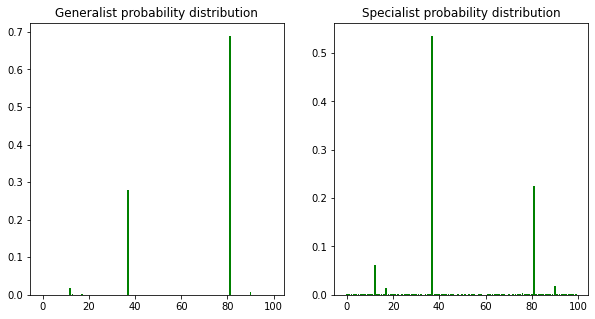

In [25]:
out = output.detach().cpu().numpy()
s_dist = np.zeros(num_classes) 
s_out = specialist_output.detach().cpu().numpy()
for i in range(len(sub_class)-1): 
    s_dist[sub_class[i]] = s_out[i]
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax1.bar(np.arange(out.shape[0]), softmax(out), color='green')
ax1.set_title("Generalist probability distribution")
ax2.bar(np.arange(s_dist.shape[0]), softmax(s_dist), color='green')
ax2.set_title("Specialist probability distribution")

In [36]:
# Example 2: Generalist wrong, specialist correct, ensemble prediction correct 
output, specialist_output, label, ensemble_predicted, q_dist, history = retrieve_iteration_history(233, 12, testloader, generalist_model, specialist_model, sub_class)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been dep

In [37]:
print("True label: {}".format(label))

True label: 81


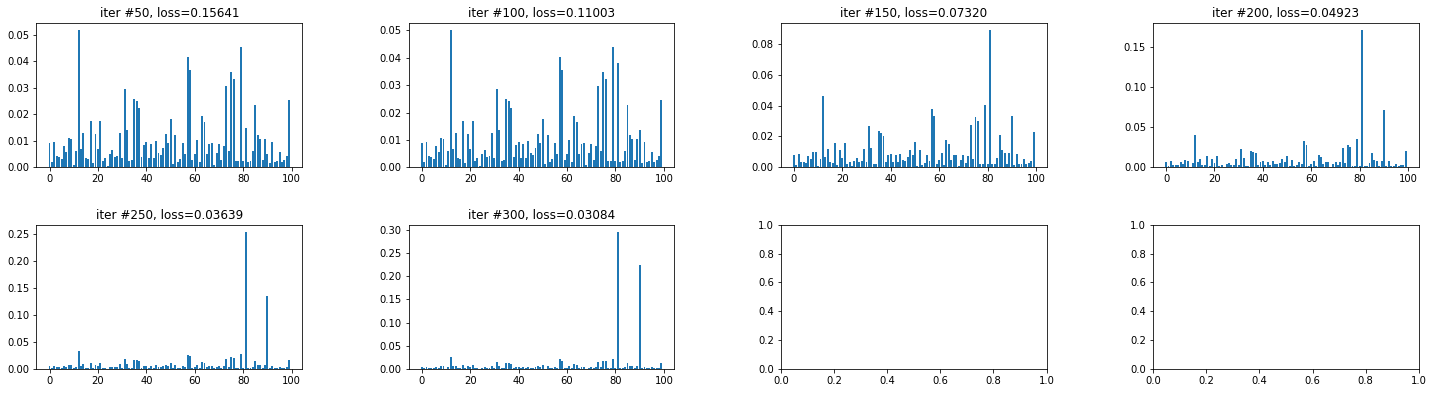

In [30]:
ncol=4
nrow=len(history)//ncol

if len(history) % ncol > 0:
    nrow += 1

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*6, nrow*3))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

for i, (niter, history_dict) in enumerate(history.items()):
    loss=history_dict['loss']
    q_logit=history_dict['logit']
    
    r=i//ncol
    c=i%ncol
    
    axes[r,c].bar(np.arange(q_logit.shape[0]), softmax(q_logit.detach().cpu().numpy()))
    axes[r,c].set_title("iter #{}, loss={:0.5f}".format(niter, loss))
    

Text(0.5, 1.0, 'Specialist probability distribution')

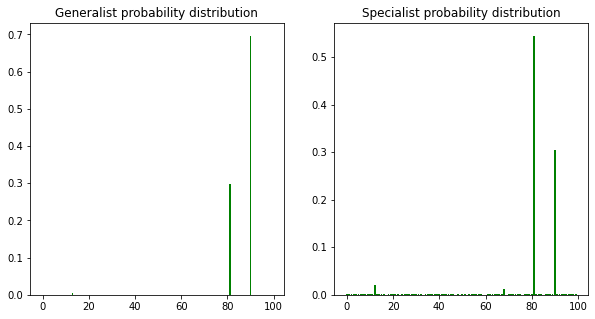

In [31]:
out = output.detach().cpu().numpy()
s_dist = np.zeros(num_classes) 
s_out = specialist_output.detach().cpu().numpy()
for i in range(len(sub_class)-1): 
    s_dist[sub_class[i]] = s_out[i]
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax1.bar(np.arange(out.shape[0]), softmax(out), color='green')
ax1.set_title("Generalist probability distribution")
ax2.bar(np.arange(s_dist.shape[0]), softmax(s_dist), color='green')
ax2.set_title("Specialist probability distribution")